{'path': '/raid/togzhan_syrymova/lump_project/data/', 'window_len': 800, 'stride_len': 160, 'num_epochs': 500, 'batch_size': 512, 'learning_rate': 0.0001, 'channels_in': 1, 'D_out': 1, 'hidden_size': 256, 'kernel_size': 15, 'stride': 3, 'dropout': 0.3, 'valid_period': 1, 'valid_size': 100, 'model_name': 'Model'}
_s_6_s_7
{'path': '/raid/togzhan_syrymova/lump_project/data/', 'window_len': 800, 'stride_len': 160, 'num_epochs': 500, 'batch_size': 512, 'learning_rate': 0.0001, 'channels_in': 1, 'D_out': 1, 'hidden_size': 256, 'kernel_size': 15, 'stride': 3, 'dropout': 0.3, 'valid_period': 1, 'valid_size': 100, 'model_name': 'Model'}
['df_train_s_6_s_7.csv']
['test_pressure_data_without_s_6_s_7.csv', 'test_pressure_data_with_s_6_s_7.csv']
['df_dev_s_6_s_7.csv']
(3072, 16800)
(1536, 16800)
(1152, 16800)
>> stride count:  3
>> stride count:  3
>> stride count:  3


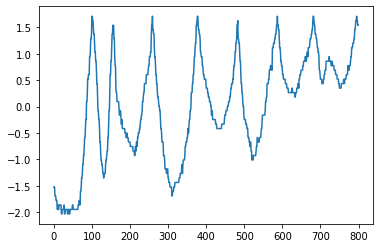

3
Dataset: (9216, 800, 15) (9216, 1) (4608, 800, 15) (4608, 1) (3456, 800, 15) (3456, 1)
train_x 
does not contain NaN values
dev_x 
does not contain NaN values
test_x 
does not contain NaN values


In [1]:
import os
os.chdir('/raid/togzhan_syrymova/lump_project/scripts/spectrogram/')
from tensorboardX import SummaryWriter
import yaml
import imp
from utils import *
INDEX = 8
var_s = ['_S_h1', '_S_h2', '_S_h3', '_M_h1', '_M_h2', '_M_h3', '_L_h1', '_L_h2', '_L_h3']
var = "_s_6_s_7"#'*raw*'#'_L_h1'
print(var)
os.chdir('/raid/togzhan_syrymova/lump_project/scripts/spectrogram/')
config = yaml.safe_load(open("config.yaml"))
print(config)
num_epochs = config['num_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
channels_in = config['channels_in']
D_out = config['D_out']
H = config['hidden_size']
kernel_size = config['kernel_size']
stride_len = config['stride']
dropout = config['dropout'] 
##
window_len = config['window_len']
stride_len = config['stride_len']
path = config['path']
################################################################
# GET DATA #
idx = 1
train_x_, train_y, dev_x_, dev_y, test_x_, test_y = read_data(window_len, stride_len, path, idx, var)
print('Dataset:', train_x_.shape, train_y.shape, dev_x_.shape, dev_y.shape, test_x_.shape, test_y.shape)
################################################################        
print('train_x ')        
check_nan(train_x_)  
print('dev_x ')        
check_nan(dev_x_)  
print('test_x ')        
check_nan(test_x_)  
################################################################

In [2]:
idx2 = 1
one_d = 1

if idx2 == 1:
    #     compute spectograms #
    f, t, train_x_ = compute_spectogram(train_x_)
    f, t, dev_x_ = compute_spectogram(dev_x_)
    f, t, test_x_ = compute_spectogram(test_x_)

    train_x = np.swapaxes(train_x_, 1, 3)
    dev_x = np.swapaxes(dev_x_, 1, 3)
    test_x = np.swapaxes(test_x_, 1, 3)

    train_x = np.swapaxes(train_x, 2, 3)
    dev_x = np.swapaxes(dev_x, 2, 3)
    test_x = np.swapaxes(test_x, 2, 3)
    
    if one_d == 1:
        train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2]*np.shape(train_x)[3])
        dev_x = dev_x.reshape(np.shape(dev_x)[0], np.shape(dev_x)[1], np.shape(dev_x)[2]*np.shape(dev_x)[3])
        test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2]*np.shape(test_x)[3])
    
else: 
    train_x = np.swapaxes(train_x_, 1, 2)
    dev_x = np.swapaxes(dev_x_, 1, 2)
    test_x = np.swapaxes(test_x_, 1, 2)

train_x, train_y = shuffle(train_x, train_y)
dev_x, dev_y = shuffle(dev_x, dev_y)
test_x, test_y = shuffle(test_x, test_y)

idx = 1
train_x, train_y  = to_tensor(train_x, train_y)
dev_x, dev_y = to_tensor(dev_x, dev_y)
test_x, test_y = to_tensor(test_x, test_y)

In [3]:
###############################################################
D_in = np.shape(train_x)[2]
print(D_in)
print('Started training')
seed = 777
torch.manual_seed(seed)
gpu_id = 13
device = torch.device("cuda:" + str(gpu_id))
################################################################
# ADAPT DIRECTORY AND MODEL NAMING
# ADD MODEL TO README OF THE FOLDER
directory = '/raid/togzhan_syrymova/lump_project/models/'
os.chdir(directory)
# DEFIEN THE MODEL
#     model = ConvLayerNet(batch_size, device, channels_in, D_out, H).to(device)
# model = ConvLayerNet3(batch_size, device, channels_in, D_in, H).to(device) batch_size, device, channels_in, D_out, H
model = SeRNN_FWXX(batch_size, device, channels_in, D_out, H).to(device)
model.to(device)
model_name = type(model).__name__
################################################################
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('# of params: ', pytorch_total_params)
################################################################  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
################################################################  
# CREATE DIR TO SAVE MODEL AND OTHEHR STUFF 
# check if the folder for the model is existing 
# if not create the folder with model name
if os.path.isdir(model_name) == False:
    os.mkdir(model_name)
opt = str(optimizer).split("(")[0]
model_name2 = model_name + '_epochs_' + str(num_epochs) + '_lr_' + str(learning_rate) + "_bs_" + str(batch_size) \
+ '_window_len_' + str(window_len) + '_stride_len_' + str(stride_len) + '_'+ str(opt).split(" ")[0] + '_' + str(criterion).split("(")[0]

model_save_path = directory + model_name + '/' + model_name2
################################################################  
# SAVE THE MODEL AND README
with open(directory + model_name + '/' + 'README_' + model_name2 + '.txt', "a") as myfile:
        myfile.write(str(model))
        myfile.write("\n OPTIMIZE: ")
        myfile.write(str(optimizer))
        myfile.write("\n CRITERION: ")
        myfile.write(str(criterion))
        myfile.write("\n")
        [myfile.write(str(items) + '\n') for items in str(config).split(", ")]
        myfile.write("\n")

print(model_name)
print(model_save_path)
print(model)
print('Start testing')
train_model(train_x, train_y, dev_x, dev_y, test_x, test_y, model, model_save_path, criterion, optimizer, device)
print('end testing')
# test_model(model_save_path, device, test_x, test_y, dev_acc_max)

exit()
    
    

387
Started training
# of params:  4978049
SeRNN_FWXX
/raid/togzhan_syrymova/lump_project/models/SeRNN_FWXX/SeRNN_FWXX_epochs_500_lr_0.0001_bs_512_window_len_800_stride_len_160_Adam_BCEWithLogitsLoss
SeRNN_FWXX(
  (lstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True)
    (1): LSTM(1, 256, batch_first=True)
    (2): LSTM(1, 256, batch_first=True)
    (3): LSTM(1, 256, batch_first=True)
    (4): LSTM(1, 256, batch_first=True)
    (5): LSTM(1, 256, batch_first=True)
    (6): LSTM(1, 256, batch_first=True)
    (7): LSTM(1, 256, batch_first=True)
    (8): LSTM(1, 256, batch_first=True)
    (9): LSTM(1, 256, batch_first=True)
    (10): LSTM(1, 256, batch_first=True)
    (11): LSTM(1, 256, batch_first=True)
    (12): LSTM(1, 256, batch_first=True)
    (13): LSTM(1, 256, batch_first=True)
    (14): LSTM(1, 256, batch_first=True)
  )
  (fc1): Linear(in_features=3840, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, o

Epoch 137/500, Train Loss: 9.174
Dev Accuracy: 0.699
Epoch 138/500, Train Loss: 9.164
Dev Accuracy: 0.706
Epoch 139/500, Train Loss: 9.130
Dev Accuracy: 0.708
Epoch 140/500, Train Loss: 9.093
Dev Accuracy: 0.707
Epoch 141/500, Train Loss: 9.058
Dev Accuracy: 0.704
Epoch 142/500, Train Loss: 9.018
Dev Accuracy: 0.704
Epoch 143/500, Train Loss: 9.008
Dev Accuracy: 0.705
Epoch 144/500, Train Loss: 8.999
Dev Accuracy: 0.709
Epoch 145/500, Train Loss: 9.006
Dev Accuracy: 0.709
Epoch 146/500, Train Loss: 8.978
Dev Accuracy: 0.710
Epoch 147/500, Train Loss: 8.945
Dev Accuracy: 0.711
Epoch 148/500, Train Loss: 8.926
Dev Accuracy: 0.707
Epoch 149/500, Train Loss: 8.899
Dev Accuracy: 0.709
Epoch 150/500, Train Loss: 8.886
Dev Accuracy: 0.707
Epoch 151/500, Train Loss: 8.886
Dev Accuracy: 0.707
Epoch 152/500, Train Loss: 8.875
Dev Accuracy: 0.703
Epoch 153/500, Train Loss: 8.893
Dev Accuracy: 0.710
Epoch 154/500, Train Loss: 8.854
Dev Accuracy: 0.711
Epoch 155/500, Train Loss: 8.875
Dev Accuracy:

Epoch 292/500, Train Loss: 4.714
Dev Accuracy: 0.711
Epoch 293/500, Train Loss: 4.674
Dev Accuracy: 0.712
Epoch 294/500, Train Loss: 4.617
Dev Accuracy: 0.711
Epoch 295/500, Train Loss: 4.604
Dev Accuracy: 0.712
Epoch 296/500, Train Loss: 4.550
Dev Accuracy: 0.709
Epoch 297/500, Train Loss: 4.470
Dev Accuracy: 0.708
Epoch 298/500, Train Loss: 4.356
Dev Accuracy: 0.708
Epoch 299/500, Train Loss: 4.232
Dev Accuracy: 0.711
Epoch 300/500, Train Loss: 4.151
Dev Accuracy: 0.708
Epoch 301/500, Train Loss: 4.038
Dev Accuracy: 0.708
Epoch 302/500, Train Loss: 3.937
Dev Accuracy: 0.706
Epoch 303/500, Train Loss: 3.847
Dev Accuracy: 0.705
Epoch 304/500, Train Loss: 3.765
Dev Accuracy: 0.705
Epoch 305/500, Train Loss: 3.713
Dev Accuracy: 0.703
Epoch 306/500, Train Loss: 3.662
Dev Accuracy: 0.707
Epoch 307/500, Train Loss: 3.621
Dev Accuracy: 0.706
Epoch 308/500, Train Loss: 3.575
Dev Accuracy: 0.706
Epoch 309/500, Train Loss: 3.542
Dev Accuracy: 0.707
Epoch 310/500, Train Loss: 3.539
Dev Accuracy:

Epoch 447/500, Train Loss: 0.465
Dev Accuracy: 0.697
Epoch 448/500, Train Loss: 0.458
Dev Accuracy: 0.697
Epoch 449/500, Train Loss: 0.451
Dev Accuracy: 0.697
Epoch 450/500, Train Loss: 0.445
Dev Accuracy: 0.698
Epoch 451/500, Train Loss: 0.440
Dev Accuracy: 0.697
Epoch 452/500, Train Loss: 0.434
Dev Accuracy: 0.698
Epoch 453/500, Train Loss: 0.429
Dev Accuracy: 0.698
Epoch 454/500, Train Loss: 0.423
Dev Accuracy: 0.698
Epoch 455/500, Train Loss: 0.417
Dev Accuracy: 0.698
Epoch 456/500, Train Loss: 0.410
Dev Accuracy: 0.697
Epoch 457/500, Train Loss: 0.404
Dev Accuracy: 0.696
Epoch 458/500, Train Loss: 0.399
Dev Accuracy: 0.697
Epoch 459/500, Train Loss: 0.396
Dev Accuracy: 0.697
Epoch 460/500, Train Loss: 0.392
Dev Accuracy: 0.696
Epoch 461/500, Train Loss: 0.387
Dev Accuracy: 0.696
Epoch 462/500, Train Loss: 0.383
Dev Accuracy: 0.696
Epoch 463/500, Train Loss: 0.379
Dev Accuracy: 0.696
Epoch 464/500, Train Loss: 0.377
Dev Accuracy: 0.694
Epoch 465/500, Train Loss: 0.378
Dev Accuracy: